In [ ]:
# Load the NeuroKit package
import neurokit2 as nk

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

from data_utils import (
    load_data_from_dir,
)
from constants import AUDIO_BLOCKS
from features.feature_utils import get_block_raw_data_by_marker
# https://www.kymat.io/codereference.html
from kymatio.numpy import Scattering1D

data_dir = "../CleandDataV2/"
random.seed(33)

In [ ]:
marker = "ECG"

subject_data_list = ["2040", "2018"]  # os.listdir(data_dir)
all_features = []
second_per_slice = 4

# num_slices = int(num_trial*((24/second_per_slice)-1)) # 5 slices per trial
subj_to_data = {}
for i, d in enumerate(subject_data_list):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subj_to_data[d] = load_data_from_dir(dir_name)

In [ ]:
def _slice_data_by_seconds(block_data, srate: int, second_per_slice: int):
    # Original shape: (num_channel, time_series_per_trial, num_trials): (128, 12288, 13)
    num_seq_per_slice = srate * second_per_slice
    # Discard the first 4 second slice because of the noise in each trial: (128, 12288-num_seq_per_slice, 13)
    trimmed_data = block_data[:, srate * 4 :, :]
    # swap trial and time series: (num_channel, num_trials, time_series_per_trial)
    trimmed_data = np.swapaxes(trimmed_data, 1, 2)
    num_trial, num_seq_per_trial = trimmed_data.shape[-2], trimmed_data.shape[-1]

    d = []
    for t in range(num_trial):
        for i in range(0, num_seq_per_trial, num_seq_per_slice):
            d.append(trimmed_data[:, t, i : i + num_seq_per_slice])
    # New shape: (num_trials*num_slices_per_trial, num_channel, time_series_per_slice):
    #  (13*num_slices_per_trial, 128, num_seq_per_slice)
    return np.stack(d, axis=0)


def _no_slice_data(block_data):
    # swap trial and time series: (num_channel, num_trials, time_series_per_trial)
    block_data = np.swapaxes(block_data, 1, 2)
    num_trial, num_seq_per_trial = block_data.shape[-2], block_data.shape[-1]

    d = []
    for t in range(num_trial):
        d.append(block_data[:, t, :])
    # New shape: (num_trials*num_slices_per_trial, num_channel, time_series_per_slice):
    #  (13*num_slices_per_trial, 128, num_seq_per_slice)
    return np.stack(d, axis=0)


def _get_block_raw_data_by_marker(subject_data, blocks, marker, second_per_slice):
    block_to_data = {}
    for b in blocks:
        block_data = subject_data[b]
        srate = block_data.get_srate(marker)
        if second_per_slice == 24:
            sliced_data = _no_slice_data(block_data.get_all_data()[marker])
        else:
            sliced_data = _slice_data_by_seconds(
                block_data.get_all_data()[marker], srate, second_per_slice
            )

        sliced_data = sliced_data[:, 0, :]
        block_to_data[b] = sliced_data

    return block_to_data

In [ ]:
subject_data = subj_to_data[subject_data_list[0]]
block_to_data = _get_block_raw_data_by_marker(subject_data, AUDIO_BLOCKS, marker, 24)
srate = int(subject_data["audio_hvha"].get_srate(marker))
block_to_data["audio_hvha"].shape

In [152]:
import pywt

def _cwt_around_rpeaks(data, srate, max_r_peaks=20):
    # heartbeat segmentation interval
    before, after = 90, 110
    wavelet = "mexh"  # mexh, morl, gaus8, gaus4
    scales = pywt.central_frequency(wavelet) * srate / np.arange(1, 4, 1)
    coeffs, frequencies = pywt.cwt(data, scales, wavelet, 1./srate)
    ecg_cleaned = nk.ecg_clean(data, sampling_rate=srate)
    peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=srate, correct_artifacts=True)
    r_peaks = np.nonzero(peaks['ECG_R_Peaks'].to_numpy())[0]
    if len(r_peaks) < max_r_peaks:
        print(r_peaks.shape)
    # for remove inter-patient variation
    #avg_rri = np.mean(np.diff(r_peaks))

    x1 = []
    for i in range(max_r_peaks+1):
        if i == 0 or i == len(r_peaks) - 1:
            continue


        # cv2.resize is used to sampling the scalogram to (100 x100)
        #print(coeffs[:, r_peaks[i] - before: r_peaks[i] + after].shape)
        x1.append(coeffs[:, r_peaks[i] - before: r_peaks[i] + after])

    return x1


#scales = np.arange(1, 31)  # No. of scales
signal = block_to_data["audio_hvha"][0]
cwtmatr = _cwt_around_rpeaks(signal, srate)  # Finding CWT using gaussian wavelet
np.array(cwtmatr).shape
# Plotting scalogram
# plt.figure(figsize=(15, 10))
# plt.imshow(cwtmatr, cmap='PRGn', aspect='auto',
#                 vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
# plt.gca().invert_yaxis()
# plt.show()

(36000,)

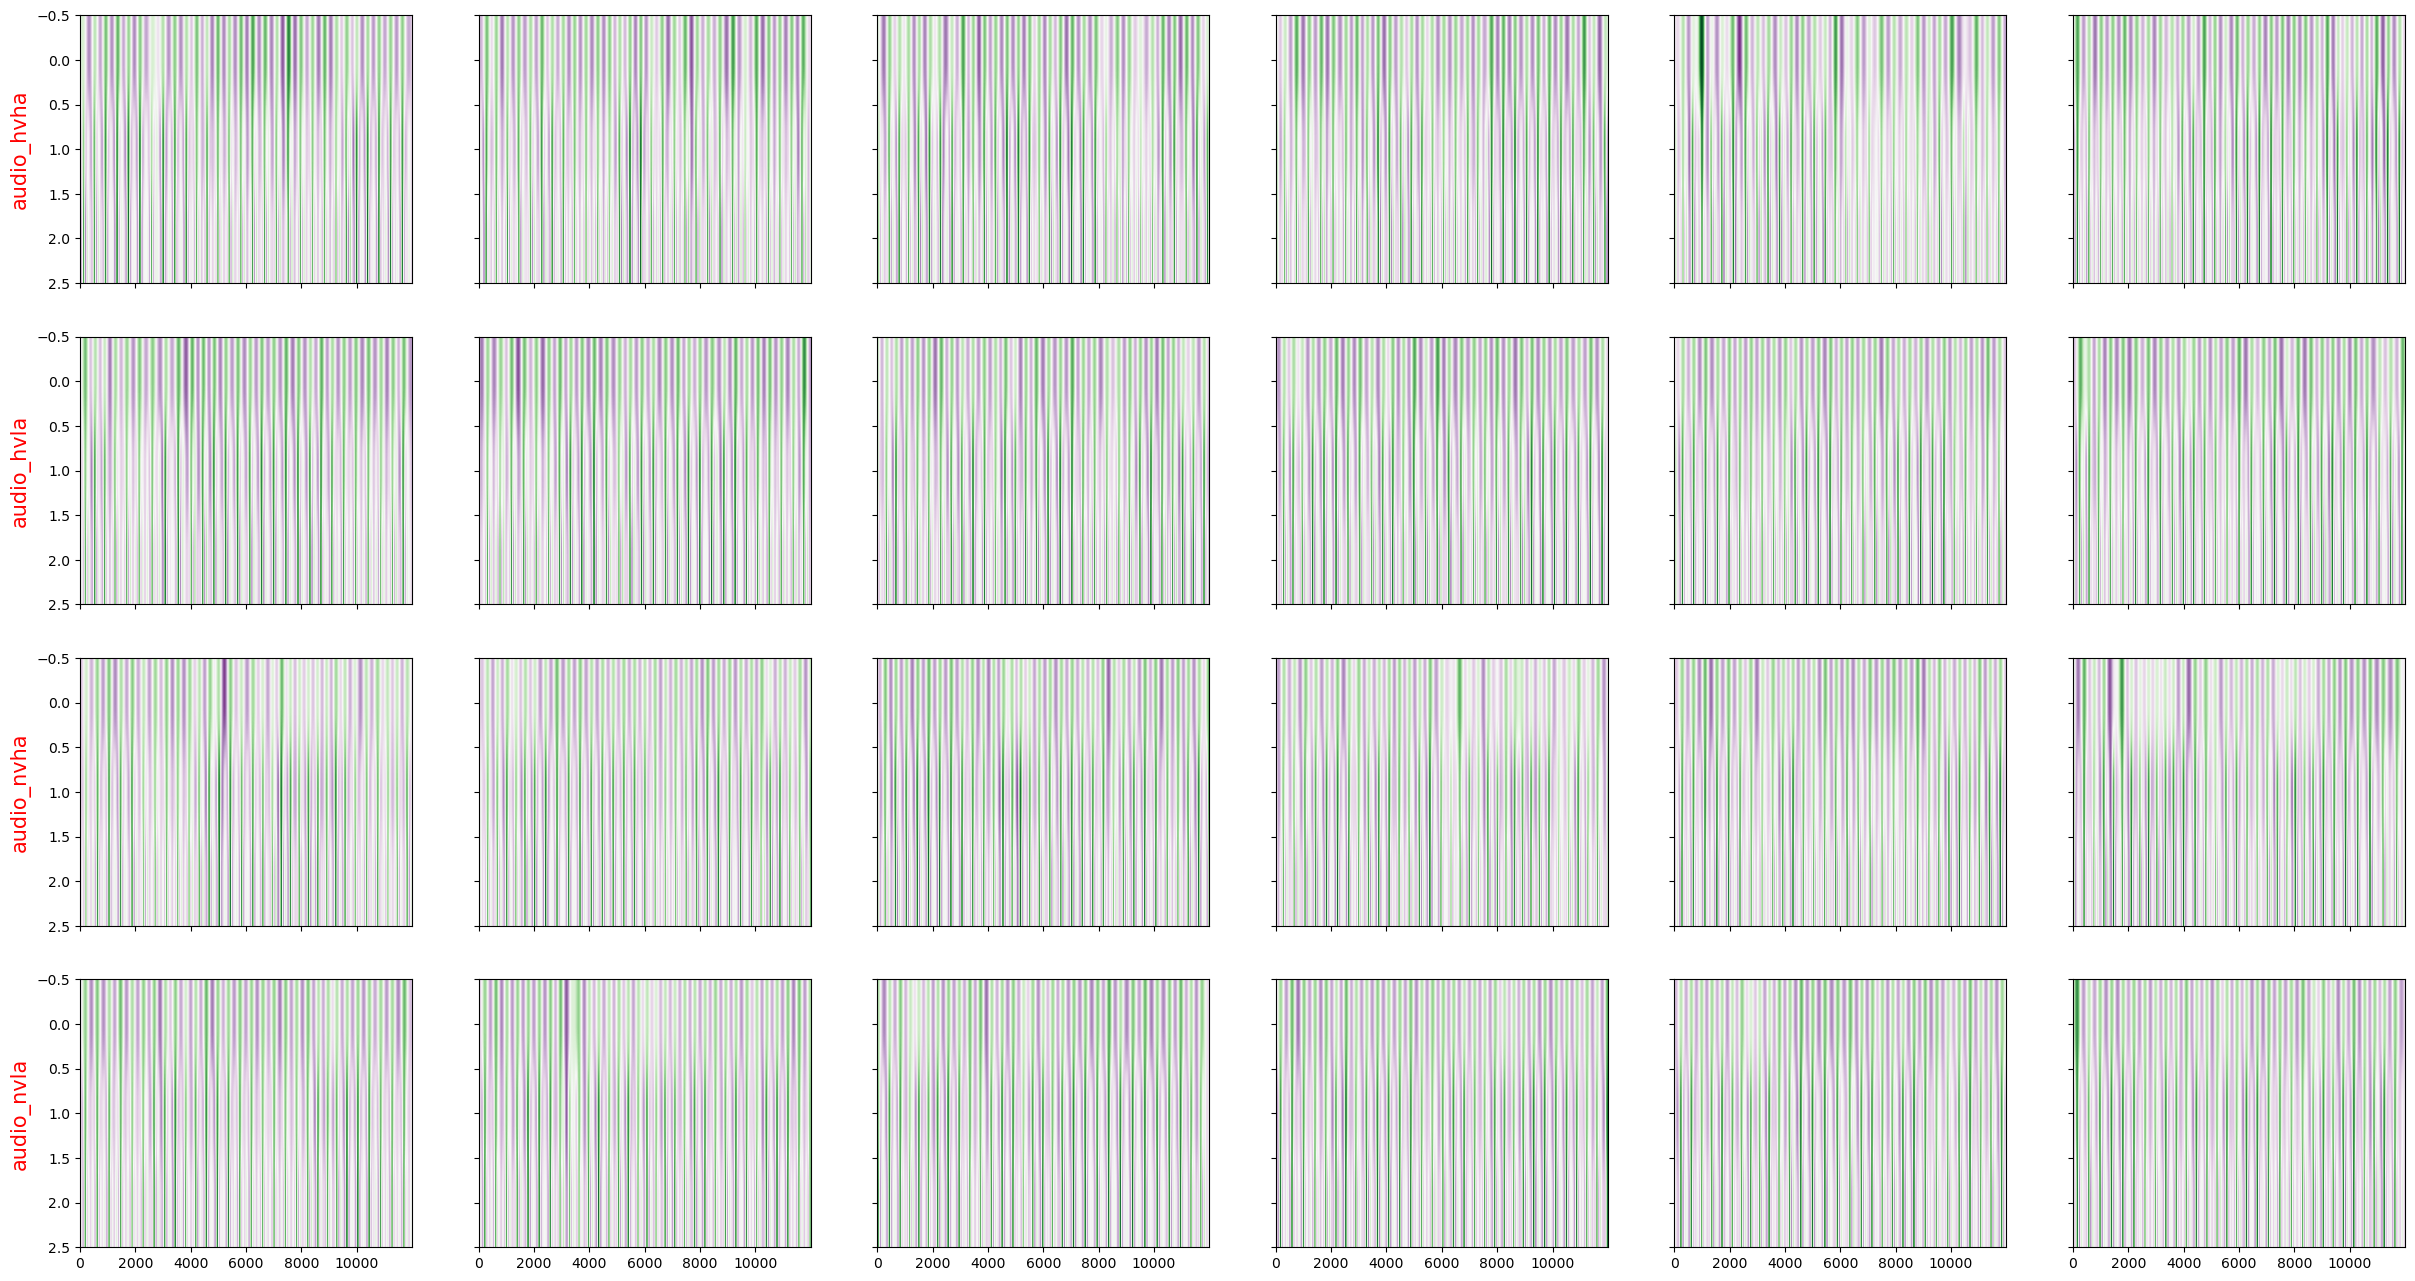

In [150]:
def continuous_wt(
    signal, sampling_rate=1000, min_frequency=0.04, max_frequency=None, nfreqbin=None
):
    import scipy.signal
    """**Continuous Wavelet Transform**

     References
     ----------
     * Neto, O. P., Pinheiro, A. O., Pereira Jr, V. L., Pereira, R., Baltatu, O. C., & Campos, L.
       A. (2016). Morlet wavelet transforms of heart rate variability for autonomic nervous system
       activity. Applied and Computational Harmonic Analysis, 40(1), 200-206.

    * Wachowiak, M. P., Wachowiak-Smolíková, R., Johnson, M. J., Hay, D. C., Power, K. E.,
      & Williams-Bell, F. M. (2018). Quantitative feature analysis of continuous analytic wavelet
      transforms of electrocardiography and electromyography. Philosophical Transactions of the
      Royal Society A: Mathematical, Physical and Engineering Sciences, 376(2126), 20170250.

    """

    # central frequency
    w = 6.0  # recommended

    if nfreqbin is None:
        nfreqbin = sampling_rate // 2

    # frequency
    frequency = np.linspace(min_frequency, max_frequency, nfreqbin)

    # time
    time = np.arange(len(signal)) / sampling_rate
    widths = w * sampling_rate / (2 * frequency * np.pi)

    # Mother wavelet = Morlet
    tfr = scipy.signal.cwt(signal, scipy.signal.morlet2, widths, w=w)

    return frequency, time, np.abs(tfr)


num_trials = 6
fig, axes = plt.subplots(
    nrows=len(AUDIO_BLOCKS),
    ncols=num_trials,
    figsize=(num_trials * 5, len(AUDIO_BLOCKS) * 4),
    sharey=True,
    sharex=True,
)
idx = 0
for block, bdata in block_to_data.items():
    axes.flat[idx].set_ylabel(
        block,
        fontsize=15,
        color="red",
    )
    for i in range(num_trials):
        wavelet = "mexh"  # mexh, morl, gaus8, gaus4
        scales = pywt.central_frequency(wavelet) * srate / np.arange(1, 4, 1)
        cwtmatr, freqs = pywt.cwt(bdata[i], scales, 'mexh', sampling_period=1./srate)  # Finding CWT using gaussian wavelet
        axes.flat[idx].imshow(cwtmatr, cmap='PRGn', aspect='auto',
                vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
        # frequency, t, tfr = continuous_wt(
        #     signal=bdata[i],
        #     sampling_rate=srate,
        #     min_frequency=0.15,
        #     max_frequency=0.4,
        #     nfreqbin=3,
        # )       
        # axes.flat[idx].pcolormesh(t, frequency, tfr, cmap=plt.get_cmap("magma"), shading="auto")
        idx += 1

# fig.suptitle(
#     "Continuous Wavelet Transform Magnitude",
#     fontsize=15,
# )

In [ ]:
num_trials = 6
fig, axes = plt.subplots(
    nrows=len(AUDIO_BLOCKS),
    ncols=num_trials,
    figsize=(num_trials * 5, len(AUDIO_BLOCKS) * 4),
    sharey=True,
    sharex=True,
)
idx = 0
for block, bdata in block_to_data.items():
    axes.flat[idx].set_ylabel(
        block,
        fontsize=15,
        color="red",
    )
    for i in range(num_trials):
        J, T, Q = 8, bdata[i].shape[-1], (8, 1)
        scattering = Scattering1D(J, T, Q)
        Sx = scattering(bdata[i])
        meta = scattering.meta()
        order0 = np.where(meta['order'] == 0)
        order1 = np.where(meta['order'] == 1)
        order2 = np.where(meta['order'] == 2)

        #ax = sns.lineplot(Sx[order0][0], ax=axes.flat[idx])
        axes.flat[idx].imshow(Sx[order1], aspect='auto')
        print(Sx[order0][0].shape)
        idx += 1

fig.suptitle(
    "Second-order scattering",
    fontsize=15,
)

## Raw data PSD

In [ ]:
# nk.signal_psd(data, sampling_rate=srate, method="welch", show=True) #, min_frequency=0.12, max_frequency=0.4)
num_slices = 6
for subj in subject_data_list:
    fig, axes = plt.subplots(
        nrows=len(AUDIO_BLOCKS),
        ncols=num_slices,
        figsize=(num_slices * 5, len(AUDIO_BLOCKS) * 4),
        sharey=True,
        sharex=True,
    )
    subject_data = subj_to_data[subj]
    block_to_data = _get_block_raw_data_by_marker(
        subject_data, AUDIO_BLOCKS, marker, 24
    )
    idx = 0
    for block, bdata in block_to_data.items():
        for i in range(num_slices):
            df = nk.signal_psd(
                bdata[i],
                sampling_rate=srate,
                method="welch",
                show=False,
                min_frequency=0,
                max_frequency=0.5,
            )

            t = int(i / 4) + 1
            ax = df.plot(
                x="Frequency", y="Power", title=f"Trial {t} slice{i}", ax=axes.flat[idx]
            )
            ax.set(xlabel="Frequency (Hz)", ylabel="Spectrum")
            # axes.flat[idx].set_xlim(0, 1)
            idx += 1
            if i == 0:
                ax.set_ylabel(
                    block,
                    fontsize=15,
                    color="red",
                )

    fig.suptitle(
        f"Subject ECG raw {subj}:{marker} - Power Spectral Density (welch method)",
        fontsize=15,
    )

## Plot HRV PSD

In [ ]:
# Find peaks
def _hrv_get_rri(peaks=None, sampling_rate=1000):
    # Compute R-R intervals (also referred to as NN) in milliseconds
    rri = np.diff(peaks) / sampling_rate * 1000
    # Impute intervals with median in case of missing values to calculate timestamps
    imputed_intervals = np.where(np.isnan(rri), np.nanmedian(rri, axis=0), rri)
    # Compute the timestamps of the intervals in seconds
    intervals_time = np.nancumsum(imputed_intervals / 1000)
    return rri, intervals_time


def _get_ecg_hrv_psd(block_data, srate: int, min_frequency=0, max_frequency=0.5):
    psd_data = []
    num_trials = block_data.shape[0]
    # loop through all trials: time -> frequency
    for t in range(num_trials):
        peaks, info = nk.ecg_peaks(bdata[t], sampling_rate=srate)
        rri, rri_time = _hrv_get_rri(peaks["ECG_R_Peaks"].values, sampling_rate=srate)
        # Process R-R intervals (interpolated at 100 Hz by default)
        rri, rri_time, sampling_rate = nk.intervals_process(
            rri,
            intervals_time=rri_time,
            interpolate=True,
            interpolation_rate=None,
        )

        df = nk.signal_psd(
            rri,
            sampling_rate=srate,
            method="welch",
            show=False,
            min_frequency=min_frequency,
            max_frequency=max_frequency,
            t=rri_time,
        )
        psd_data.append(df.Power.values)

    return np.stack(psd_data, axis=0)

In [ ]:
num_slices = 6
for subj in subject_data_list:
    fig, axes = plt.subplots(
        nrows=len(AUDIO_BLOCKS),
        ncols=num_slices,
        figsize=(num_slices * 5, len(AUDIO_BLOCKS) * 4),
        sharey=True,
        sharex=True,
    )
    subject_data = subj_to_data[subj]
    block_to_data = _get_block_raw_data_by_marker(
        subject_data, AUDIO_BLOCKS, marker, 24
    )
    idx = 0
    for block, bdata in block_to_data.items():
        for i in range(num_slices):
            peaks, info = nk.ecg_peaks(bdata[i], sampling_rate=srate)
            rri, rri_time = _hrv_get_rri(
                peaks["ECG_R_Peaks"].values, sampling_rate=srate
            )
            # Process R-R intervals (interpolated at 100 Hz by default)
            rri, rri_time, sampling_rate = nk.intervals_process(
                rri,
                intervals_time=rri_time,
                interpolate=True,
                interpolation_rate=None,
            )
            # ax = axes.flat[idx]
            # ax.plot(peaks['ECG_R_Peaks'].values)

            df = nk.signal_psd(
                rri,
                sampling_rate=srate,
                method="welch",
                show=False,
                min_frequency=0,
                max_frequency=0.5,
                t=rri_time,
            )
            t = int(i / 2) + 1  # i+1 #
            ax = df.plot(
                x="Frequency", y="Power", title=f"Trial {t} slice{i}", ax=axes.flat[idx]
            )
            ax.set(xlabel="Frequency (Hz)", ylabel="Spectrum")

            idx += 1
            if i == 0:
                ax.set_ylabel(
                    block,
                    fontsize=15,
                    color="red",
                )

    fig.suptitle(
        f"{subj}:{marker} HRV - Power Spectral Density (welch method)", fontsize=15
    )

## Load all ECG data

In [ ]:
sec_per_slice = 24
max_freq = 0.5

ecg_raw, subject_lists = [], []
all_features = []
for i, d in enumerate(os.listdir(data_dir)):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    data = load_data_from_dir(dir_name)
    block_to_data = _get_block_raw_data_by_marker(
        data, AUDIO_BLOCKS, marker, sec_per_slice
    )
    ecg_raw.append(block_to_data)
    subject_lists.append(d)

    # features = []
    # for b in AUDIO_BLOCKS:
    #     block_data = block_to_data[b]
    #     psd_data = _get_ecg_hrv_psd(block_data, srate, 0, max_freq)
    #     features = np.vstack((psd_data, features)) if len(features) > 0 else psd_data
    # all_features.append(features)
    # print(f'Finishing {d} with features {features[0].shape}')

In [ ]:
# with open(f'data/ecg_raw.pkl', 'wb') as handle:
#     d = {'ecg_raw': ecg_raw}
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./data/ecg_raw.pkl", "rb") as fp:
    d = pickle.load(fp)
    ecg_raw = d["ecg_raw"]
len(ecg_raw)

## Continous Wavelet Transform

In [153]:
def _scipy_cwt_around_rpeaks(data, srate, nfreqbin=3, max_r_peaks=12):
    # heartbeat segmentation interval
    before, after = 90, 110
    frequency, t, tfr = continuous_wt(
        signal=data,
        sampling_rate=srate,
        min_frequency=0.04,
        max_frequency=0.5,
        nfreqbin=nfreqbin,
    ) 
    ecg_cleaned = nk.ecg_clean(data, sampling_rate=srate)
    peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=srate, correct_artifacts=True)
    r_peaks = np.nonzero(peaks['ECG_R_Peaks'].to_numpy())[0]
    # for remove inter-patient variation
    #avg_rri = np.mean(np.diff(r_peaks))

    x1 = []
    for i in range(max_r_peaks+1):
        if i == 0 or i == len(r_peaks) - 1:
            continue


        # cv2.resize is used to sampling the scalogram to (100 x100)
        #print(coeffs[:, r_peaks[i] - before: r_peaks[i] + after].shape)
        x1.append(tfr[:, r_peaks[i] - before: r_peaks[i] + after])

    return x1

def _get_cwt_around_rpeaks(ecg_raw, srate):
    block_swu_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            x = data[t]
            tfr = _cwt_around_rpeaks(
                data=x,
                srate=srate,
                max_r_peaks=12,
            ) 

            feature = np.array(tfr).ravel()
            block_swu_f.append(feature)
            
    print('Finished extract continous wavelets...')
    return block_swu_f

cwt_features = [
    _get_cwt_around_rpeaks(data, srate) for data in ecg_raw
]
cwt_features = np.array(cwt_features)
cwt_features.shape


Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continous wavelets...
Finished extract continou

(41, 52, 36000)

In [154]:
with open(f"data/cwt_features.pkl", "wb") as handle:
    d = {"cwt_features": cwt_features}
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Scattering Wavelet Transform

In [ ]:
def _get_sacttering_wavelets_features(ecg_raw, J, Q):
    block_swu_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            x = data[t]
            T = x.shape[-1]
            scattering = Scattering1D(J, T, Q)
            Sx = scattering(x)

            meta = scattering.meta()
            order0 = np.where(meta["order"] == 0)
            order1 = np.where(meta["order"] == 1)
            order2 = np.where(meta["order"] == 2)
            feature = np.vstack([Sx[order0][0], Sx[order1], Sx[order2]])
            block_swu_f.append(feature)
            
    print('Finished extract scattering wavelets...')
    return block_swu_f


# define scattering
J = 8
Q = (8, 1)
sacttering_wavelets_features = [
    _get_sacttering_wavelets_features(data, J, Q) for data in ecg_raw
]
sacttering_wavelets_features = np.array(sacttering_wavelets_features)
sacttering_wavelets_features.shape

## NK lib exploeration

In [ ]:
data = ecg_raw[0]["audio_hvha"][0]
ecg_signals, info = nk.ecg_process(data, sampling_rate=srate)

nk.ecg_plot(ecg_signals, info)
fig = plt.gcf()
fig.set_size_inches(14, 9, forward=True)

In [ ]:
# Extract clean EDA and SCR features
data = ecg_raw[0]["audio_hvha"][0]
# Clean signal and Find peaks
ecg_cleaned = nk.ecg_clean(data, sampling_rate=srate)
peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=srate, correct_artifacts=True)
# Compute HRV indices
hrv_indices = nk.hrv(peaks, sampling_rate=srate, show=True)
hrv_indices.keys()

In [ ]:
np.nonzero(peaks['ECG_R_Peaks'].to_numpy())

In [ ]:
def _get_hrv_feature(ecg_raw):
    block_hrv_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            cleaned = nk.ecg_clean(data[t], sampling_rate=srate, method="neurokit")
            peaks, info = nk.ecg_peaks(
                cleaned, sampling_rate=srate, correct_artifacts=True
            )
            hrv_feature = nk.hrv(peaks, sampling_rate=srate, show=False)
            block_hrv_f.append(hrv_feature)
    return block_hrv_f


def _get_rr_feature(ecg_raw):
    block_hrv_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            cleaned = nk.ecg_clean(data[t], sampling_rate=srate, method="neurokit")
            peaks, info = nk.ecg_peaks(
                cleaned, sampling_rate=srate, correct_artifacts=True
            )
            rri, rri_time = _hrv_get_rri(
                peaks["ECG_R_Peaks"].values, sampling_rate=srate
            )

            # Process R-R intervals (interpolated at 100 Hz by default)
            rri, rri_time, _ = nk.intervals_process(
                rri,
                intervals_time=rri_time,
                interpolate=True,
                interpolation_rate=None,
            )
            df = nk.signal_psd(
                rri,
                sampling_rate=srate,
                method="welch",
                show=False,
                min_frequency=0,
                max_frequency=0.5,
                t=rri_time,
            )
            block_hrv_f.append(df["Frequency"].values)
    return block_hrv_f


def _get_rr_peaks(ecg_raw):
    block_hrv_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            cleaned = nk.ecg_clean(data[t], sampling_rate=srate, method="neurokit")
            peaks, info = nk.ecg_peaks(
                cleaned, sampling_rate=srate, correct_artifacts=True
            )
            block_hrv_f.append(peaks["ECG_R_Peaks"].values)
    return block_hrv_f


def _get_cardia_phases(ecg_raw):
    block_hrv_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            cleaned = nk.ecg_clean(data[t], sampling_rate=srate, method="neurokit")
            _, rpeaks = nk.ecg_peaks(cleaned)
            signals, waves = nk.ecg_delineate(cleaned, rpeaks, sampling_rate=srate)
            cardiac_phase = nk.ecg_phase(
                ecg_cleaned=cleaned,
                rpeaks=rpeaks,
                delineate_info=waves,
                sampling_rate=srate,
            )
            block_hrv_f.append(cardiac_phase["ECG_Phase_Completion_Atrial"])
    return block_hrv_f


# all_hrv_features = [ _get_hrv_feature(data) for data in ecg_raw]
all_rr_features = [_get_rr_feature(data) for data in ecg_raw]
np.array(all_rr_features).shape

In [ ]:
# np.array(all_rr_features).shape
with open(f"data/ecg_rr_peak_freq.pkl", "wb") as handle:
    d = {"ecg_rr_peak_freq": np.array(all_rr_features)}
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Read labels pkl file with slicing behavioral
with open("./data/behavioral_labels.pkl", "rb") as fp:
    behavioral_labels = pickle.load(fp)

sliced_valence_labels, sliced_arousal_labels, _ = (
    behavioral_labels["valence_labels"],
    behavioral_labels["arousal_labels"],
    behavioral_labels["attention_labels"],
)

# Load labels without slice
num_slice_per_trial = 5
valence_labels, arousal_labels = [], []
for si in range(len(sliced_valence_labels)):
    vls, als = sliced_valence_labels[si], sliced_arousal_labels[si]
    filter_indexes = np.arange(0, len(vls), num_slice_per_trial)
    valence_labels.append(np.array(vls)[filter_indexes])
    arousal_labels.append(np.array(als)[filter_indexes])

In [ ]:
from scipy import stats


def _extact_hrv_feature_by_name(block_hrv_features, feature_key="HRV_SDNN"):
    return [hrv_f[feature_key].values[0] for hrv_f in block_hrv_features]


feature_key = "HRV_SD1"  # HRV_VHF, HRV_HFn
for l, labels in {"valence": valence_labels, "arousal": arousal_labels}.items():
    n_row, n_col = (5, 8)
    fig, axes = plt.subplots(
        nrows=n_row,
        sharey=False,
        ncols=n_col,
        figsize=(n_col * 3, n_row * 3),
    )

    for i, ax in enumerate(axes.flat):
        s = str(subject_lists[i])

        block_hrv_std = _extact_hrv_feature_by_name(all_hrv_features[i], feature_key)
        r_v, p_v = stats.pearsonr(labels[i], block_hrv_std)

        color = "red" if p_v < 0.05 else "grey"
        result = pd.DataFrame({"user rating": labels[i], "hrv_std": block_hrv_std})
        g1 = sns.regplot(data=result, x="user rating", y="hrv_std", ax=ax, color=color)
        g1.set(xlabel=None, ylabel=None)
        g1.set_title(f"{s} r:{r_v:2.4f}, p:{p_v:2.4f}", fontsize=12, color=color)

    fig.suptitle(f"{feature_key} vs user rating - {l}", y=1)
    fig.tight_layout(pad=1.8)

In [ ]:
time_features = []
f_names = [
    "HRV_MeanNN",
    "HRV_SDNN",
    "HRV_RMSSD",
    "HRV_MinNN",
    "HRV_MaxNN",
    "HRV_MedianNN",
    "HRV_MadNN",
    "HRV_MCVNN",
    "HRV_IQRNN",
    "HRV_Prc20NN",
    "HRV_Prc80NN",
    "HRV_SDRMSSD",
]
for sub_data in all_hrv_features:
    block_features = [data[f_names].values[0] for data in sub_data]
    time_features.append(block_features)
time_features = np.array(time_features)
# with open(f'data/ecg_time_features.pkl', 'wb') as handle:
#     d = {'ecg_time_features': time_features}
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Time-Frequency Domain - HRV

In [ ]:
# Import function for Morlet Wavelets
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform


def _get_hrv_tf_with_wavelet(ecg_raw, n_cycles=0.5):
    # Settings for the wavelet transform algorithm
    freqs = np.linspace(0.15, 0.5, 3)
    block_hrv_tf = []
    for b in AUDIO_BLOCKS:
        for sig in ecg_raw[b]:
            cleaned = nk.ecg_clean(sig, sampling_rate=srate, method="neurokit")
            peaks, _ = nk.ecg_peaks(
                cleaned, sampling_rate=srate, correct_artifacts=True
            )
            rri, rri_time = _hrv_get_rri(
                peaks["ECG_R_Peaks"].values, sampling_rate=srate
            )
            # Process R-R intervals (interpolated at 100 Hz by default)
            rri, rri_time, _ = nk.intervals_process(
                rri,
                intervals_time=rri_time,
                interpolate=True,
                interpolation_rate=None,
            )
            # Compute wavelet transform using compute Morlet wavelet transform algorithm
            mwt = compute_wavelet_transform(
                rri, fs=srate, n_cycles=n_cycles, freqs=freqs
            )
            block_hrv_tf.append(abs(mwt).ravel())
    return np.array(block_hrv_tf)


all_mwt = [_get_hrv_tf_with_wavelet(subj_data) for subj_data in ecg_raw]
np.array(all_mwt).shape

In [ ]:
with open(f"data/ecg_time_freq_wavelet.pkl", "wb") as handle:
    d = {"ecg_time_freq_wavelet": np.array(all_mwt)}
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
n_seconds = 24
times = create_times(n_seconds, srate)

for b in AUDIO_BLOCKS:
    sig = ecg_raw[0][b][1]  # [:6000]
    cleaned = nk.ecg_clean(sig, sampling_rate=srate, method="neurokit")
    peaks, info = nk.ecg_peaks(cleaned, sampling_rate=srate, correct_artifacts=True)
    rri, rri_time = _hrv_get_rri(peaks["ECG_R_Peaks"].values, sampling_rate=srate)
    # Process R-R intervals (interpolated at 100 Hz by default)
    rri, rri_time, sampling_rate = nk.intervals_process(
        rri,
        intervals_time=rri_time,
        interpolate=True,
        interpolation_rate=None,
    )
    # Settings for the wavelet transform algorithm
    freqs = np.linspace(0.15, 0.4, 2)
    # Compute wavelet transform using compute Morlet wavelet transform algorithm
    mwt = compute_wavelet_transform(rri, fs=srate, n_cycles=0.25, freqs=freqs)
    # Plot morlet wavelet transform
    plot_timefrequency(times, freqs, mwt)
    # Plot a segment of our simulated time series
    # plot_time_series(times, sig, xlim=[0, 24])